In [2]:
from models.models import SequenceDNN_Regression
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
%matplotlib inline

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5005)
/usr/local/anaconda3/envs/regression_dragonn_new/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [14]:
def get_seqs():
    key_to_seq = OrderedDict()
    seq_len = 145
    with open("../data/Scaleup_counts_sequences/ScaleUpDesign1.sequences.txt") as f:
        for line in f:
            key, seq = line.strip().split()
            if "N" in seq:
                seq = seq.replace("N", "A")
            assert key not in key_to_seq
            key_to_seq[key] = seq

    with open("../data/Scaleup_counts_sequences/ScaleUpDesign2.sequences.txt") as f:
        for line in f:
            key, seq = line.strip().split()
            if "N" in seq:
                seq = seq.replace("N", "A")
            assert key not in key_to_seq
            key_to_seq[key] = seq
    return key_to_seq

bases = ['A', 'T', 'C', 'G']

def one_hot_encode_seq(seq):
    result = np.zeros((len(bases), len(seq)))
    for i, base in enumerate(seq):
        result[bases.index(base), i] = 1
    return result

def seqs_to_encoded_matrix(seqs):
    # Wrangle the data into a shape that Dragonn wants.
    result = np.concatenate(
        map(one_hot_encode_seq, seqs)
    ).reshape(
        len(seqs), 1, len(bases), len(seqs[0])
    )

    # Check we actually did the encoding right.
    for i in range(len(seqs)):
        for j in range(len(seqs[0])):
            assert sum(result[i, 0, :, j]) == 1

    return result

X = seqs_to_encoded_matrix(get_seqs().values())

In [5]:
fn = 'models/models/100n1_100n2_8w1_15w2_act'
model = SequenceDNN_Regression.load(fn + '.arch.json', fn + '.weights.h5')

In [13]:
model.plot_architecture('test.png')
X.shape

(487137, 1, 4, 145)

In [47]:
deeplift = model.in_silico_mutagenesis(X[:10000])

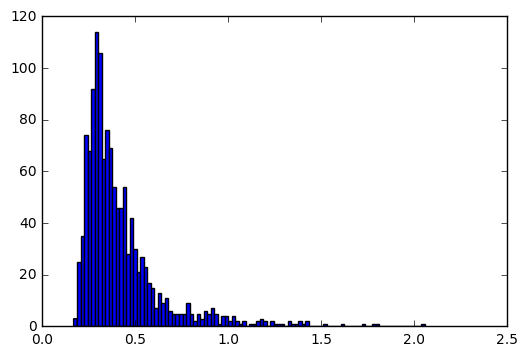

In [53]:
plt.hist(np.abs(deeplift[0, range(15, 10000, 31)]).max(axis = 3).flatten(), bins = 100)
plt.show()

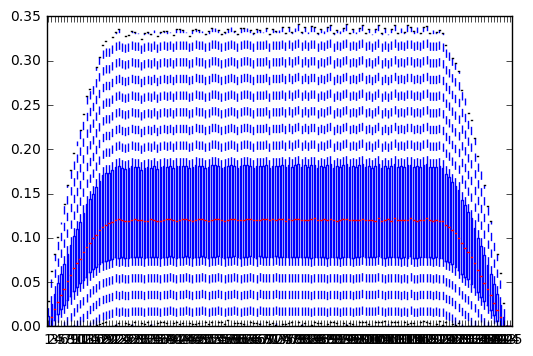

In [50]:
plt.boxplot(np.abs(deeplift[0]).max(axis = 2).reshape(10000, 145), showfliers=False)
plt.show()

In [51]:
deeplift.shape

(4, 10000, 1, 4, 145)

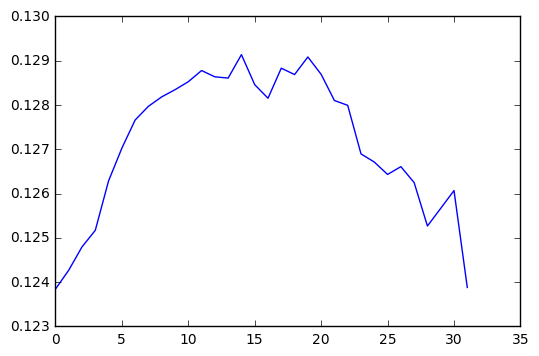

In [170]:
plt.plot([np.abs(deeplift[0, range(i, 10000, 31), :, :, :]).max(axis = 2).mean() for i in range(32)])
plt.show()

In [153]:
np.save('test.npy', deeplift)

In [154]:
test = np.load('test.npy')

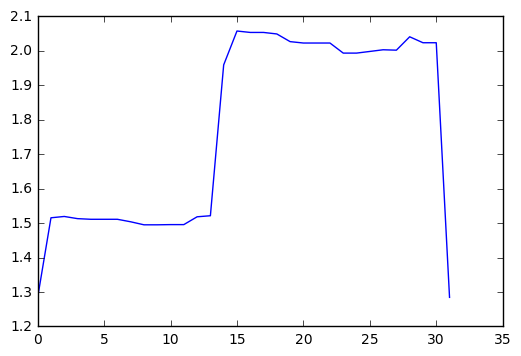

In [171]:
plt.plot([np.abs(test[0, range(i, 3000, 31), :, :, :]).max(axis = 2).max() for i in range(32)])
plt.show()

In [213]:
predictions = model.predict(X)

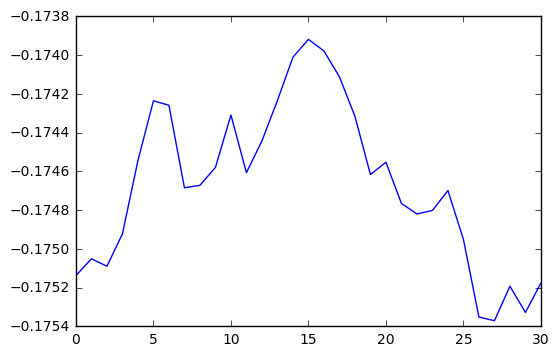

In [222]:
plt.plot([predictions[range(i, predictions.shape[0], 31), 0].mean() for i in range(31)])
plt.show()

In [185]:
predictions.shape

(487137, 4)

In [6]:
model.deeplift(X[:100])

RuntimeError: There is a layer after your target layer but it is not an activation layer, which seems odd...if doing regression, make sure to set the target layer to the last layer

In [10]:
import deeplift
from deeplift.conversion import keras_conversion as kc

deeplift_model = kc.convert_sequential_model(
                    model.model,
                    nonlinear_mxts_mode=deeplift.blobs.NonlinearMxtsMode.DeepLIFT)

deeplift_contribs_func = deeplift_model.get_target_contribs_func(
                            find_scores_layer_idx=0,
                            target_layer_idx=-1)

In [ ]:
scores = np.array(deeplift_contribs_func(task_idx=0,
                                         input_data_list=[X],
                                         batch_size=128,
                                         progress_update=1000))

No reference provided - using zeros
Done 0
Done 16000
Done 32000
Done 48000
Done 64000
Done 80000
Done 96000
Done 112000
Done 128000
Done 144000
Done 160000


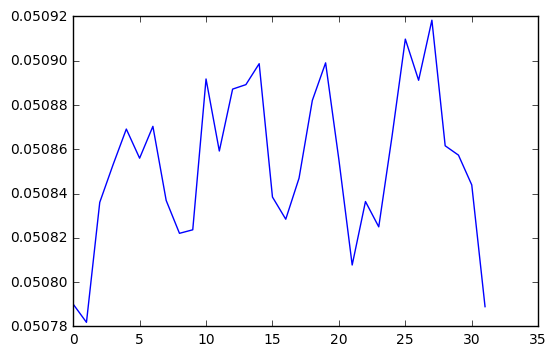

In [38]:
plt.plot([np.abs(scores[range(i, 100000, 31), :, :, :]).max(axis = 2).mean() for i in range(32)])
plt.show()

In [31]:
scores[range(i, 100000, 31), :, :, 45:100].max(axis = 2).shape

(3225, 1, 55)